# Example using lorenz-96 model in eWaterCycle


In [1]:
# general python
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
import numpy as np
import os
from pathlib import Path
import yaml
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import scipy
import xarray as xr
from tqdm import tqdm
import glob
from devtools import pprint

In [2]:
# general eWC
import ewatercycle
import ewatercycle.forcing
import ewatercycle.models

Ensure correct package is installed:
```bash
pip install ewatercycle-lorenz
```
<br>

In [5]:
from ewatercycle.models import Lorenz

In [6]:
from ewatercycle.forcing import sources

In [7]:
experiment_start_date = "1997-08-01T00:00:00Z"
experiment_end_date = "1997-08-20T00:00:00Z"
path = Path.cwd()

In [8]:
forcing = sources.LorenzForcing(start_time = experiment_start_date,
                      end_time = experiment_end_date,
                      directory = path,
                      F=8,
                      dt=1e-3)

In [9]:
model = Lorenz(forcing=forcing)

In [10]:
J = 40
common_state = np.zeros(J)
common_state[19] = 0.01

In [11]:
config, _ = model.setup(J=J,
                        start_state=list(common_state))

In [12]:
model.initialize(config)

In [13]:
n_timesteps = int((model.end_time - model.start_time) /  model.time_step)
pbar = tqdm(total=n_timesteps)

output = pd.DataFrame(columns = ['truth'])
while model.time < model.end_time:
    model.update()
    output.loc[model.time_as_datetime] = model.get_value("state")[5]
    
    pbar.update(1)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 18990/19000 [01:40<00:00, 183.26it/s]

In [14]:
pbar.close()
model.finalize()

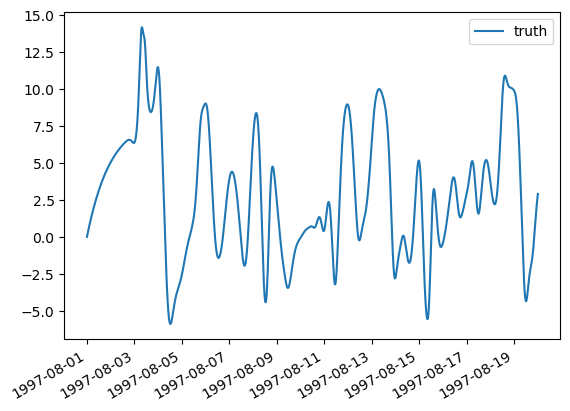

In [15]:
output.plot();

In [16]:
N = 2 #numeber of ensemble members

#start with  an empty ensemble
ensemble = []

for n in range (N):
    #add an ensemble methods
    ensemble.append(Lorenz(forcing=forcing))
    config, _ = ensemble[n].setup(J=J, start_state=list(common_state))
    ensemble[n].initialize(config)

    ensemble_member_state = np.array(ensemble[n].get_value('state'))
    ensemble_member_state[5] = ensemble_member_state[5] + np.random.randn(1)[0]*0.01
    ensemble[n].set_value('state', ensemble_member_state)
    
    #also add a column to the output dataframe to store the output
    output['ensemble' + str(n)]= np.nan    

In [17]:
ref_model = ensemble[0]

In [ ]:
#run the Ensemble. We will use the time of the first ensemble member to keep time, assuming that all
#models use the same time steps.
n_timesteps = int((ref_model.end_time - ref_model.start_time) /  ref_model.time_step)
# pbar = tqdm(total=n_timesteps) # some issue with double loops

while ensemble[0].time < ensemble[0].end_time:
    #loop through the ensemble members and store the state after each update
    for n in range (N):
        ensemble[n].update()
        output.at[ensemble[n].time_as_datetime,'ensemble' + str(n)] = ensemble[n].get_value('state')[5]
    # pbar.update(1) # visual

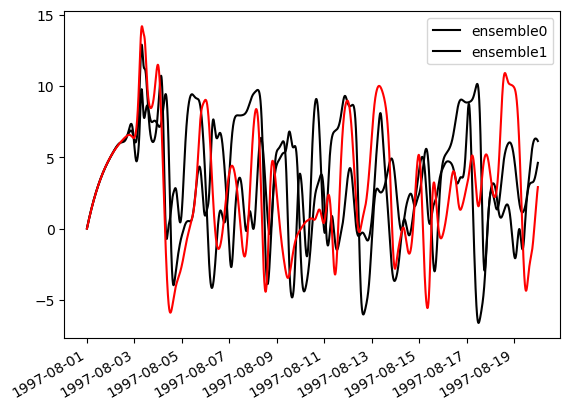

In [19]:
output.loc[:,'ensemble0':].plot(color='k')
output.loc[:,'truth'].plot(color='r');

In [20]:
for n in range (N):
     ensemble[n].finalize()